In [1]:
import torch
from torch import nn
from utils_torch import *
import utils_torch as ut

# LSTM

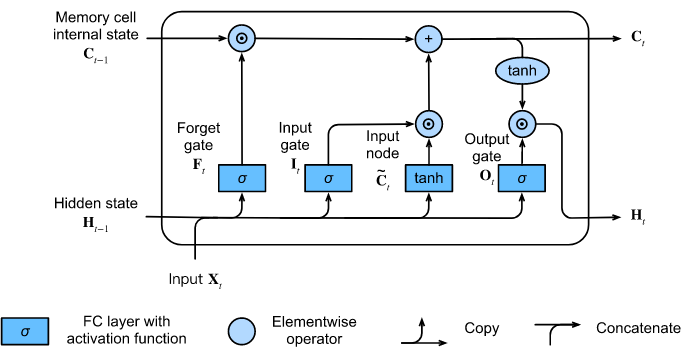 

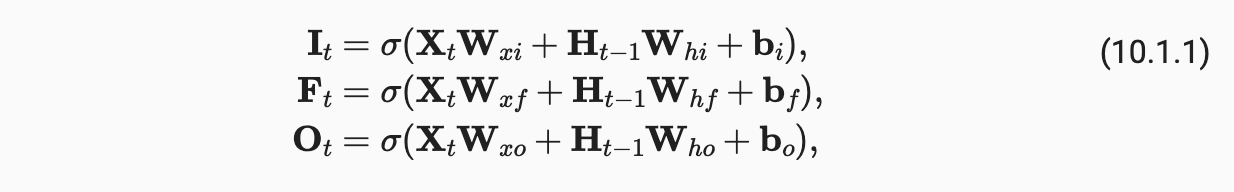
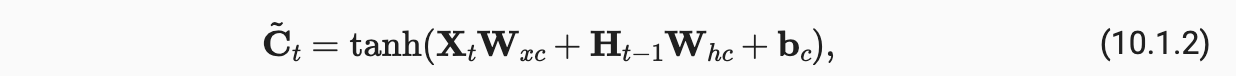
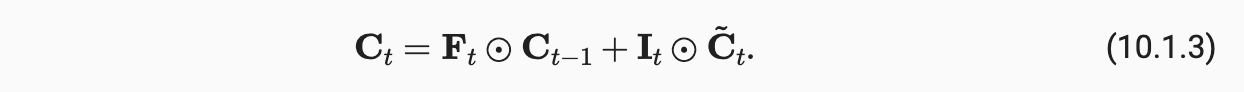
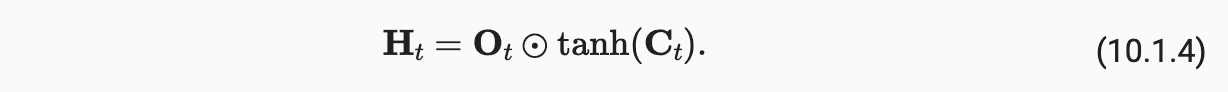

## Implementation from Scratch

In [2]:
class LSTM(Module):
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()

        init_weight = lambda *shape: nn.Parameter(torch.randn(*shape) * sigma)

        def triple(): return (
            init_weight(num_inputs, num_hiddens),
            init_weight(num_hiddens, num_hiddens),
            nn.Parameter(torch.zeros(num_hiddens))
        )

        self.W_xi, self.W_hi, self.b_i = triple()  # Input gate
        self.W_xf, self.W_hf, self.b_f = triple()  # Forget gate
        self.W_xo, self.W_ho, self.b_o = triple()  # Output gate
        self.W_xc, self.W_hc, self.b_c = triple()  # Input node

    def forward(self, X, H_C=None):
        if H_C is None:
            # Initial state with shape: (batch_size, num_hiddens)
            H = torch.zeros((X.shape[1], self.num_hiddens), device=X.device)
            C = torch.zeros((X.shape[1], self.num_hiddens), device=X.device)
        else:
            H, C = H_C

        outputs = []
        for x in X:
            I = torch.sigmoid(torch.matmul(x, self.W_xi) +
                              torch.matmul(H, self.W_hi) + self.b_i)
            F = torch.sigmoid(torch.matmul(x, self.W_xf) +
                              torch.matmul(H, self.W_hf) + self.b_f)
            O = torch.sigmoid(torch.matmul(x, self.W_xo) +
                              torch.matmul(H, self.W_ho) + self.b_o)
            C_tilde = torch.tanh(torch.matmul(
                x, self.W_xc) + torch.matmul(H, self.W_hc) + self.b_c)
            C = F * C + I * C_tilde
            H = O * torch.tanh(C)
            outputs.append(H)
        return outputs, (H, C)

### Trainig

In [3]:
data = ut.TimeMachine(batch_size=1024, num_steps=100)
lstm = LSTM(num_inputs=len(data.vocab), num_hiddens=32)
model = ut.RNNLMScratch(lstm, vocab_size=len(data.vocab), lr=0.01)
trainer = ut.Trainer(max_epochs=10, gradient_clip_val=1, number_of_gpus=0)

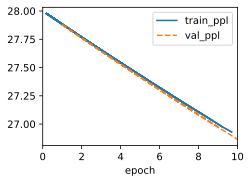

In [4]:
trainer.fit(model, data)

## Concise Implementation

In [11]:
class LSTMTorch(Module):
    def __init__(self, num_inputs, num_hiddens):
        super().__init__()
        self.save_hyperparameters()
        self.rnn = nn.LSTM(num_inputs, num_hiddens)

    def forward(self, X, H_C=None):
        return self.rnn(X, H_C)

In [14]:
class RNNLM(RNNLMScratch):
    """The RNN-based language model implemented with high-level APIs.
    Defined in :numref:`sec_rnn-concise`"""

    def init_params(self):
        self.linear = nn.LazyLinear(self.vocab_size)

    def output_layer(self, hiddens):
        return swapaxes(self.linear(hiddens), 0, 1)

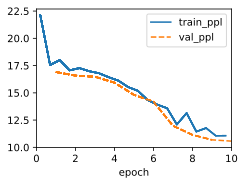

In [15]:
lstm = LSTMTorch(num_inputs=len(data.vocab), num_hiddens=32)
model = RNNLM(lstm, vocab_size=len(data.vocab), lr=4)
trainer.fit(model, data)

In [16]:
model.predict('it has', 20, data.vocab, try_gpu())

'it has an the the the the '

# Gated Recurrent Units (GRU)
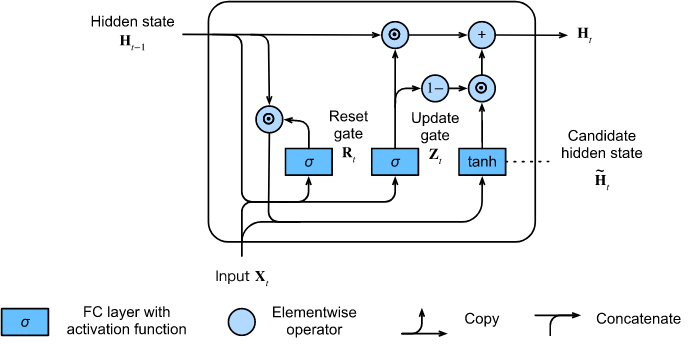


## Implementation from Scratch

In [2]:
class GRU(Module):
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        # draw the weights from a Gaussian distribution
        # with standard deviation to be sigma and set the bias to 0.
        init_weight = lambda *shape: nn.Parameter(torch.randn(*shape) * sigma)

        def triple(): return (
            init_weight(num_inputs, num_hiddens),
            init_weight(num_hiddens, num_hiddens),
            nn.Parameter(torch.zeros(num_hiddens))
        )

        self.W_xr, self.W_hr, self.b_r = triple()  # reset gate
        self.W_xz, self.W_hz, self.b_z = triple()  # update gate
        self.W_xh, self.W_hh, self.b_h = triple()  # candidate hidden state

    def forward(self, X, H=None):
        if H is None:
            # Initial state with shape: (batch_size, num_hiddens)
            H = torch.zeros((X.shape[1], self.num_hiddens))

        outputs = []
        for x in X:
            R = torch.sigmoid(torch.matmul(x, self.W_xr) +
                              torch.matmul(H, self.W_hr) + self.b_r)
            Z = torch.sigmoid(torch.matmul(x, self.W_xz) +
                              torch.matmul(H, self.W_hz) + self.b_z)
            H_tilde = torch.tanh(torch.matmul(
                x, self.W_xh) + torch.matmul(R * H, self.W_hh) + self.b_h)
            H = Z * H + (1-Z) * H_tilde
            outputs.append(H)
        return outputs, H

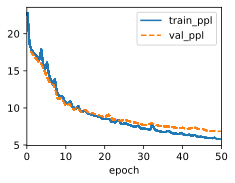

In [4]:
data = TimeMachine(batch_size=1024, num_steps=32)
gru = GRU(num_inputs=len(data.vocab), num_hiddens=32)
model = RNNLMScratch(gru, vocab_size=len(data.vocab), lr=4)
trainer = Trainer(max_epochs=50, gradient_clip_val=1, number_of_gpus=0)
trainer.fit(model, data)

## Concise Implementation

In [3]:
class GRUTorch(RNN):
    def __init__(self, num_inputs, num_hiddens):
        Module.__init__(self)
        self.save_hyperparameters()
        self.rnn = nn.GRU(num_inputs, num_hiddens)

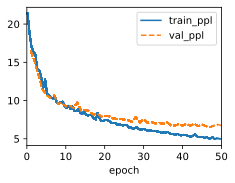

In [6]:
data = TimeMachine(batch_size=1024, num_steps=32)
gru = GRUTorch(num_inputs=len(data.vocab), num_hiddens=32)
model = RNNLM(gru, vocab_size=len(data.vocab), lr=4)
trainer = Trainer(max_epochs=50, gradient_clip_val=1, number_of_gpus=0)
trainer.fit(model, data)

In [8]:
model.predict('it has', 20, data.vocab,)

'it has one of so mest and '

Gated RNNs like LSTMs and GRUs can better capture dependencies for sequences with large time step distances. GRUs contain basic RNNs as their extreme case whenever the reset gate is switched on. They can also skip subsequences by turning on the update gate.

# Deep Recurrent Neural Networks
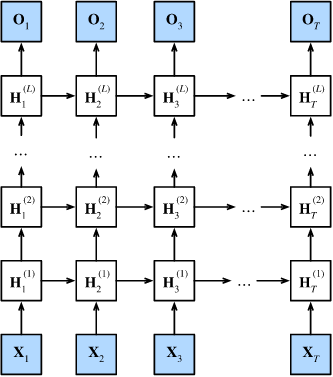

In [39]:
class StackedRNN(Module):
    def __init__(self, num_inputs, num_hiddens, num_layers, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.rnns = nn.Sequential(*[RNNScratch(num_inputs=num_inputs if i == 0 else num_hiddens,
                                               num_hiddens=num_hiddens, sigma=sigma) for i in range(num_layers)])

    def forward(self, X, Hs=None):
        # multi-layer forward computation performs forward computation layer by layer.
        outputs = X
        if Hs is None:
            Hs = [None] * self.num_layers
        for i in range(self.num_layers):
            outputs, Hs[i] = self.rnns[i](outputs, Hs[i])
            outputs = torch.stack(outputs, 0)
        return outputs, Hs

In [116]:
X = data.train_dataloader().dataset.tensors[0][:1024, :]

X = model.one_hot(X)

In [118]:
self = StackedRNN(num_inputs=len(data.vocab),
                  num_hiddens=32,
                  num_layers=2)
Hs = None
outputs = X
if Hs is None:
    Hs = [None] * self.num_layers
for i in range(self.num_layers):
    outputs, Hs[i] = self.rnns[i](outputs, Hs[i])
    outputs = torch.stack(outputs, 0)

In [120]:
len(outputs), outputs[0].shape, self.num_hiddens

(32, torch.Size([1024, 32]), 32)

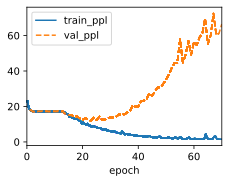

In [57]:
rnn_block = StackedRNN(num_inputs=len(data.vocab),
                       num_hiddens=32,
                       num_layers=2)
model = RNNLMScratch(rnn_block, vocab_size=len(data.vocab), lr=2)
trainer = Trainer(max_epochs=70, gradient_clip_val=0)
trainer.fit(model, data)

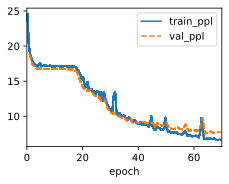

In [60]:
data = TimeMachine(batch_size=1024, num_steps=32)
rnn_block = StackedRNN(num_inputs=len(data.vocab),
                       num_hiddens=32,
                       num_layers=2)
model = RNNLMScratch(rnn_block, vocab_size=len(data.vocab), lr=2)
trainer = Trainer(max_epochs=70, gradient_clip_val=1)
trainer.fit(model, data)

## Concise Implementation

In [87]:
class GRU2(RNN):
    def __init__(self, num_inputs=len(data.vocab),
                 num_hiddens=32,
                 num_layers=2, dropout=0):
        Module.__init__(self)
        self.save_hyperparameters()
        self.rnn = nn.GRU(num_inputs, num_hiddens, num_layers, dropout=dropout)

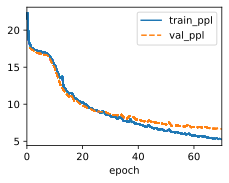

In [88]:
gru = GRU2(num_inputs=len(data.vocab),
           num_hiddens=32,
           num_layers=2)
model = RNNLM(gru, vocab_size=len(data.vocab), lr=2)
trainer.fit(model, data)

In [ ]:
model.predict('it has', 20, data.vocab)

# Bidirectional Recurrent Neural Networks
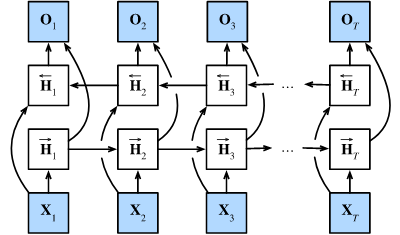

In [121]:
class BiRNN(Module):
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.f_rnn = RNNScratch(num_inputs, num_hiddens, sigma=0.01)
        self.b_rnn = RNNScratch(num_inputs, num_hiddens, sigma=0.01)
        self.num_hiddens *= 2  # The output dimension will be doubled

    def forward(self, X, Hs=None):
        f_H, b_H = Hs if Hs is not None else (None, None)
        f_outputs, f_H = self.f_rnn(X, f_H)
        b_outputs, b_H = self.b_rnn(reversed(X), b_H)
        outputs = [torch.cat((f, b), -1)
                   for f, b in zip(f_outputs, reversed(b_outputs))]
        return outputs, (f_H, b_H)

`torch.cat`: Concatenates the given sequence of :attr:`seq` tensors in the given dimension.
All tensors must either have the same shape (except in the concatenating
dimension) or be empty.

In [122]:
data = TimeMachine(batch_size=1024, num_steps=32)
birnn_block = BiRNN(num_inputs=len(data.vocab), num_hiddens=32)
model = RNNLMScratch(birnn_block, vocab_size=len(data.vocab), lr=2)

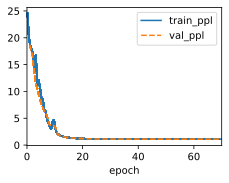

In [123]:
trainer = Trainer(max_epochs=70, gradient_clip_val=1)
trainer.fit(model, data)

## Concise Implementation

In [124]:
class BiGRU(RNN):
    def __init__(self, num_inputs, num_hiddens):
        Module.__init__(self)
        self.save_hyperparameters()
        self.rnn = nn.GRU(num_inputs, num_hiddens, bidirectional=True)
        self.num_hiddens *= 2

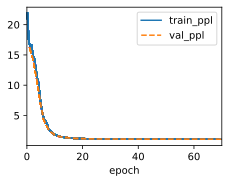

In [125]:
bigru = BiGRU(num_inputs=len(data.vocab), num_hiddens=32)
model = RNNLM(bigru, vocab_size=len(data.vocab), lr=2)
trainer.fit(model, data)

# Machine Translation and the Dataset

### Downloading and Preprocessing the Dataset

In [66]:
class MTFraEng(DataModule):
    def __init__(self, batch_size, num_steps=9, num_train=512, num_val=128):
        super(MTFraEng, self).__init__()
        self.save_hyperparameters()
        self.arrays, self.src_vocab, self.tgt_vocab = self._build_arrays(
            self._download())
    
    def _build_arrays(self, raw_text, src_vocab=None, tgt_vocab=None):
        def _build_array(sentences, vocab, is_tgt=False):
            # truncation and padding so that every sequence in the same minibatch should have the same length num_steps
            pad_or_trim = lambda seq, t: (
                seq[:t] if len(seq) > t else seq + ['<pad>'] * (t - len(seq)))
            sentences = [pad_or_trim(s, self.num_steps) for s in sentences]
            if is_tgt:
                # the special beginning-of-sequence “<bos>” token will be used as the first input token for predicting the target sequence
                sentences = [['<bos>'] + s for s in sentences]
            if vocab is None:
                vocab = Vocab(sentences, min_freq=2)
            array = torch.tensor([vocab[s] for s in sentences])
            valid_len = (array != vocab['<pad>']).type(torch.int32).sum(1)
            return array, vocab, valid_len
        src, tgt = self._tokenize(self._preprocess(raw_text),
                                  self.num_train + self.num_val)
        src_array, src_vocab, src_valid_len = _build_array(src, src_vocab)
        tgt_array, tgt_vocab, _ = _build_array(tgt, tgt_vocab, True)
        return ((src_array, tgt_array[:,:-1], src_valid_len, tgt_array[:,1:]),
                src_vocab, tgt_vocab)


    def _download(self):
        extract(download(DATA_URL+'fra-eng.zip',
                folder=self.root))
        with open(self.root+'/fra-eng/fra.txt', encoding='utf-8') as f:
            return f.read()

    def _preprocess(self, text):
        # Replace non-breaking space with space
        text = text.replace('\u202f', ' ').replace('\xa0', ' ')

        # Insert space between words and punctuation marks
        def no_space(ch, prev_ch): return ch in ',.!?' and prev_ch != ' '
        out = [' ' + ch if i >
               0 and no_space(ch, text[i-1]) else ch for i, ch in enumerate(text.lower())]
        return ''.join(out)

    def _tokenize(self, text, max_examples=None):
        """tokenizes the first max_examples text sequence pairs, 
        where each token is either a word or a punctuation mark.
        """
        src, tgt = [], []
        for i, line in enumerate(text.split('\n')):
            if max_examples and i > max_examples: break
            parts = line.split('\t')
            if len(parts) == 2:
                # Skip empty tokens
                src.append([t for t in f'{parts[0]} <eos>'.split(' ') if t])
                tgt.append([t for t in f'{parts[1]} <eos>'.split(' ') if t])
        
        return src, tgt
    
    def get_dataloader(self, train):
        idx = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader(self.arrays, train, idx)

    def build(self, src_sentences, tgt_sentences):
        #  a pair of source and target sequences that are processed by the above _build_arrays method
        raw_text = '\n'.join([src + '\t' + tgt for src, tgt in zip(
            src_sentences, tgt_sentences)])
        arrays, _, _ = self._build_arrays(
            raw_text, self.src_vocab, self.tgt_vocab)
        return arrays


In [11]:
data = MTFraEng(4)
raw_text = data._download()

In [12]:
print(raw_text[:75])

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !



#### Preprocessing
replace non-breaking space with space, convert uppercase letters to lowercase ones, and insert space between words and punctuation marks.

In [13]:
text = data._preprocess(raw_text)
print(text[:75])

go .	va !
hi .	salut !
run !	cours !
run !	courez !
who ?	qui ?
wow !	ça al


### Tokenization

In [15]:
src, tgt = data._tokenize(text)
src[:9], tgt[:9]

([['go', '.', '<eos>'],
  ['hi', '.', '<eos>'],
  ['run', '!', '<eos>'],
  ['run', '!', '<eos>'],
  ['who', '?', '<eos>'],
  ['wow', '!', '<eos>'],
  ['fire', '!', '<eos>'],
  ['help', '!', '<eos>'],
  ['jump', '.', '<eos>']],
 [['va', '!', '<eos>'],
  ['salut', '!', '<eos>'],
  ['cours', '!', '<eos>'],
  ['courez', '!', '<eos>'],
  ['qui', '?', '<eos>'],
  ['ça', 'alors', '!', '<eos>'],
  ['au', 'feu', '!', '<eos>'],
  ['à', "l'aide", '!', '<eos>'],
  ['saute', '.', '<eos>']])

In [65]:
data = MTFraEng(batch_size=3)
src,tgt,src_valid_len,label = next(iter(data.train_dataloader()))
print('source:', src.type(torch.int32))
print('decoder input:', tgt.type(torch.int32))
print('source len excluding pad:', src_valid_len.type(torch.int32))
print('label:', label.type(torch.int32))


source: tensor([[180, 174,   2,   3,   4,   4,   4,   4,   4],
        [  5, 111,   2,   3,   4,   4,   4,   4,   4],
        [ 84, 190,   0,   3,   4,   4,   4,   4,   4]], dtype=torch.int32)
decoder input: tensor([[  3,   6,   0,   4,   5,   5,   5,   5,   5],
        [  3,  83,   6,   2,   4,   5,   5,   5,   5],
        [  3, 105,  94,   0,   4,   5,   5,   5,   5]], dtype=torch.int32)
source len excluding pad: tensor([4, 4, 4], dtype=torch.int32)
label: tensor([[  6,   0,   4,   5,   5,   5,   5,   5,   5],
        [ 83,   6,   2,   4,   5,   5,   5,   5,   5],
        [105,  94,   0,   4,   5,   5,   5,   5,   5]], dtype=torch.int32)


In [74]:
data = MTFraEng(batch_size=3, num_steps=10, num_train=10000, num_val=5000)
src, tgt, _,  _ = data.build(['hi .'], ['salut .'])
print('source:', data.src_vocab.to_tokens(src[0].type(torch.int32)))
print('target:', data.tgt_vocab.to_tokens(tgt[0].type(torch.int32)))

source: ['hi', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']
target: ['<bos>', 'salut', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


In [76]:
len(data.src_vocab),len(data.tgt_vocab)

(2015, 3118)

# The Encoder-Decoder Architecture
Encoder-decoder architectures can handle inputs and outputs that both consist of variable-length sequences and thus are suitable for seq2seq problems such as machine translation. 

An encoder-decoder architecture consisting of two major components: 
1. Encoder: takes a variable-length sequence as input and transforms it into a state with a fixed shape;
2. Decoder: acts as a conditional language model, taking in the encoded input and the leftwards context of the target sequence and predicting the subsequent token in the target sequence.

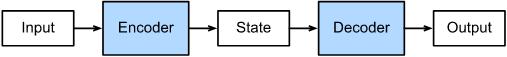

## Encoder

In [2]:
class Encoder(nn.Module):
    """The base encoder interface for the encoder-decoder architecture."""

    def __init__(self):
        super().__init__()

    # Later there can be additional arguments (e.g., length excluding padding)
    def forward(self, X, *args):
        # encoder takes variable-length sequences as input X
        raise NotImplementedError

To generate a variable-length sequence token by token, every time the decoder may map an input (e.g., the generated token at the previous time step) and the encoded state into an output token at the current time step.

## Decoder

In [3]:
class Decoder(nn.Module):  # @save
    """The base decoder interface for the encoder-decoder architecture."""

    def __init__(self):
        super().__init__()

    # Later there can be additional arguments (e.g., length excluding padding)
    def init_state(self, enc_all_outputs, *args):
        # convert the encoder output (enc_all_outputs) into the encoded state.
        raise NotImplementedError

    def forward(self, X, state):
        raise NotImplementedError

## EncoderDecoder

In [4]:
class EncoderDecoder(Classifier):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, enc_X, dec_X, *args):
        # the encoder is used to produce the encoded state
        enc_all_outputs = self.encoder(enc_X, *args)
        # this state will be used by the decoder as one of its input.
        dec_state = self.decoder.init_state(enc_all_outputs, *args)
        return self.decoder(dec_X, dec_state)[0]
    
    def predict_step(self, batch, device, num_steps, save_attention_weights=False):
        batch = [a.to(device) for a in batch]
        
        src, tgt, src_valid_len, _ = batch
        enc_all_outputs = self.encoder(src, src_valid_len)
        dec_state = self.decoder.init_state(enc_all_outputs, src_valid_len)
        outputs, attention_weights = [tgt[:, 0].unsqueeze(1), ], []
        for _ in range(num_steps):
            Y, dec_state = self.decoder(outputs[-1], dec_state)
            outputs.append(Y.argmax(2))
            # Save attention weights (to be covered later)
            if save_attention_weights:
                attention_weights.append(self.decoder.attention_weights)
        return torch.cat(outputs[1:], 1), attention_weights
        

# Encoder-Decoder Seq2Seq for Machine Translation 
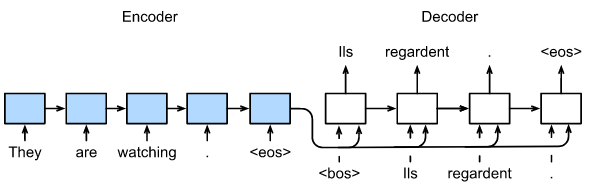


## Encoder

In [5]:
def init_seq2seq(module):
    """Initialize weights for Seq2Seq."""
    if type(module) == nn.Linear:
        pass
    if type(module) == nn.GRU:
        """
           module._flat_weights_names = ['weight_ih_l0',
                                         'weight_hh_l0',
                                         'bias_ih_l0',
                                         'bias_hh_l0',
                                         'weight_ih_l1',
                                         'weight_hh_l1',
                                         'bias_ih_l1',
                                         'bias_hh_l1']
        """
        for param in module._flat_weights_names:

            if "weight" in param:
                nn.init.xavier_uniform_(module._parameters[param])


class Seq2SeqEncoder(Encoder):
    def __init__(self, vocab_size, embed_size,
                 num_hiddens, num_layers, dropout=0):
        super().__init__()
        # an embedding layer to obtain the feature vector for each token in the input sequence.
        # The weight of an embedding layer is a matrix,
        # number of rows corresponds to the size of the input vocabulary (vocab_size);
        # number of columns corresponds to the feature vector’s dimension (embed_size).
        # For any input token index i, the embedding layer fetches the i-th row (starting from 0) of 
        # the weight matrix to return its feature vector
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = GRU(embed_size, num_hiddens, num_layers, dropout)
        self.apply(init_seq2seq)

    def forward(self, X, *args):
        # X shape: (batch_size, num_steps)
        embs = self.embedding(X.t().type(torch.int64))
        # embs shape: (num_steps, batch_size, embed_size)
        outputs, state = self.rnn(embs)
        # outputs shape: (num_steps, batch_size, num_hiddens)
        # state shape: (num_layers, batch_size, num_hiddens)
        return outputs, state

In [6]:
# instantiate a two-layer GRU encoder whose number of hidden units is 16
vocab_size, embed_size, num_hiddens, num_layers = 10, 8, 16, 2
batch_size, num_steps = 4, 9
encoder = Seq2SeqEncoder(vocab_size, embed_size, num_hiddens, num_layers)
X = torch.zeros((batch_size, num_steps))
enc_outputs, enc_state = encoder(X)

In [7]:
enc_outputs.shape, enc_state.shape

(torch.Size([9, 4, 16]), torch.Size([2, 4, 16]))

`nn.Embedding`:

```
A simple lookup table that stores embeddings of a fixed dictionary and size.

This module is often used to store word embeddings and retrieve them using indices.
The input to the module is a list of indices, and the output is the corresponding
word embeddings.

Args:
    num_embeddings (int): size of the dictionary of embeddings
    embedding_dim (int): the size of each embedding vector
```

In [8]:
embedding = nn.Embedding(10, 3)
input = torch.LongTensor([[1, 2, 4, 5], [4, 3, 2, 9]])
embedding(input)[0]

tensor([[-1.7941, -1.2195,  1.3436],
        [-0.6432, -0.2195, -1.2940],
        [-1.0203,  0.3168,  0.4610],
        [-0.3039,  0.5864, -0.0328]], grad_fn=<SelectBackward0>)

In [9]:
embedding.weight

Parameter containing:
tensor([[-0.3991, -0.2848,  0.3868],
        [-1.7941, -1.2195,  1.3436],
        [-0.6432, -0.2195, -1.2940],
        [-1.3724, -0.9477, -0.1179],
        [-1.0203,  0.3168,  0.4610],
        [-0.3039,  0.5864, -0.0328],
        [ 0.6044, -0.6549,  0.1777],
        [-1.3069, -0.6891,  1.4500],
        [-0.2487, -0.3510,  0.6552],
        [-0.4698, -0.3021, -1.1433]], requires_grad=True)

## Decoder 
- Use the hidden state at the final time step of the encoder to initialize the hidden state of the decoder. This requires that the RNN encoder and the RNN decoder have the same number of layers and hidden units.
- To further incorporate the encoded input sequence information, the context variable is concatenated with the decoder input at all the time steps. 
- To predict the probability distribution of the output token, we use a fully connected layer to transform the hidden state at the final layer of the RNN decoder.

In [10]:
class Seq2SeqDecoder(Decoder):
    def __init__(self, vocab_size, embed_size,
                 num_hiddens, num_layers, dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = GRU(embed_size+num_hiddens,
                       num_hiddens, num_layers, dropout)
        self.dense = nn.LazyLinear(vocab_size)
        self.apply(init_seq2seq)

    def init_state(self, enc_all_outputs, *args):
        return enc_all_outputs

    def forward(self, X, state):
        # X shape: (batch_size, num_steps)
        # embs shape: (num_steps, batch_size, embed_size)
        embs = self.embedding(X.t().type(torch.int32))
        enc_output, hidden_state = state
        # context shape: (batch_size, num_hiddens)
        context = enc_output[-1]
        # Broadcast context to (num_steps, batch_size, num_hiddens)
        context = context.repeat(embs.shape[0], 1, 1)
        # Concat at the feature dimension
        embs_and_context = torch.cat((embs, context), -1)
        outputs, hidden_state = self.rnn(embs_and_context, hidden_state)
        outputs = self.dense(outputs).swapaxes(0, 1)
        # outputs shape: (batch_size, num_steps, vocab_size)
        # hidden_state shape: (num_layers, batch_size, num_hiddens)
        return outputs, [enc_output, hidden_state]

In [11]:
vocab_size, embed_size, num_hiddens, num_layers = 10, 8, 16, 2
batch_size, num_steps = 4, 9

decoder = Seq2SeqDecoder(vocab_size, embed_size, num_hiddens, num_layers)
# Use the hidden state at the final time step of the encoder to
# initialize the hidden state of the decoder.
state = decoder.init_state(encoder(X))
dec_outputs, state = decoder(X, state)

/home/nancy/.local/lib/python3.8/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '




To summarize, the layers in the above RNN encoder-decoder model 
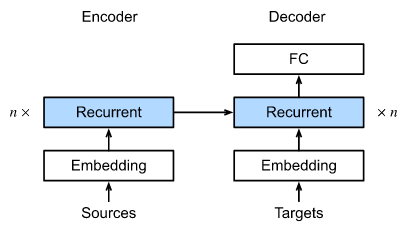


## Encoder-Decoder for Sequence to Sequence Learning

In [12]:
class Seq2Seq(EncoderDecoder):
    def __init__(self, encoder, decoder, tgt_pad, lr):
        super().__init__(encoder, decoder)
        self.save_hyperparameters()

    def validation_step(self, batch):
        Y_hat = self(*batch[:-1])
        self.plot('loss', self.loss(Y_hat, batch[-1]), train=False)

    def configure_optimizers(self):
        # Adam optimizer is used here
        return torch.optim.Adam(self.parameters(), lr=self.lr)

    def loss(self, Y_hat, Y):
        # Loss Function with Masking
        """
        Recall that <pad> tokens are appended to the end of sequences 
        so sequences of varying lengths can be efficiently loaded in minibatches of the same shape.
        However, prediction of padding tokens should be excluded from loss calculations. 
        To this end, we can mask irrelevant entries with zero values 
        so that multiplication of any irrelevant prediction with zero equals to zero.
        """
        l = super().loss(Y_hat, Y, averaged=False)
        mask = (Y.reshape(-1) != self.tgt_pad).type(torch.float32)
        return (l*mask).sum()/mask.sum()

## Training

In [13]:
data = MTFraEng(batch_size=128)

In [14]:
embed_size, num_hiddens, num_layers, dropout = 256, 256, 2, 0.2
encoder = Seq2SeqEncoder(len(data.src_vocab), embed_size,num_hiddens, num_layers, dropout)
decoder = Seq2SeqDecoder(len(data.tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
model = Seq2Seq(encoder, decoder, data.tgt_vocab['<pad>'], 0.005)

In [15]:
trainer = Trainer(max_epochs=30, gradient_clip_val=1, number_of_gpus=0)

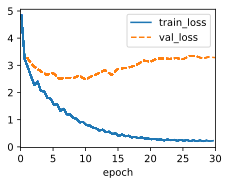

In [16]:
trainer.fit(model, data)

## Prediction
To predict the output sequence at each step, the predicted token from the previous time step is fed into the decoder as an input. One simple strategy is to sample whichever token the decoder has assigned the highest probability when predicting at each step. As in training, at the initial time step the beginning-of-sequence (“<bos>”) token is fed into the decoder. When the end-of-sequence (“<eos>”) token is predicted, the prediction of the output sequence is complete.
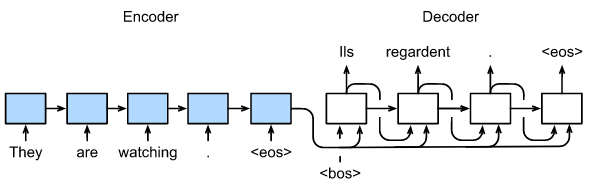

In [ ]:
ABCDEF
ABBCD

## Evaluation of Predicted Sequences
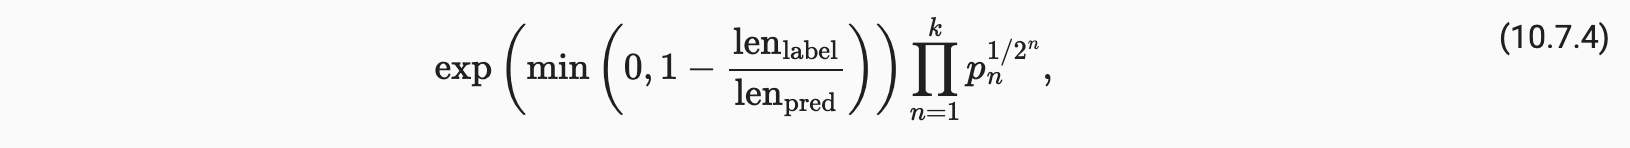

In [17]:
def bleu(pred_seq, label_seq, k):  #@save
    """Compute the BLEU."""
    pred_tokens, label_tokens = pred_seq.split(' '), label_seq.split(' ')
    len_pred, len_label = len(pred_tokens), len(label_tokens)
    score = math.exp(min(0, 1 - len_label / len_pred))
    for n in range(1, min(k, len_pred) + 1):
        num_matches, label_subs = 0, collections.defaultdict(int)
        for i in range(len_label - n + 1):
            label_subs[' '.join(label_tokens[i: i + n])] += 1
        for i in range(len_pred - n + 1):
            if label_subs[' '.join(pred_tokens[i: i + n])] > 0:
                num_matches += 1
                label_subs[' '.join(pred_tokens[i: i + n])] -= 1
        score *= math.pow(num_matches / (len_pred - n + 1), math.pow(0.5, n))
    return score

In [18]:
engs = ['go .', 'i lost .', 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']

In [19]:
preds, _ = model.predict_step(data.build(engs, fras, ), cpu(), data.num_steps)
for en, fr, p in zip(engs, fras, preds):
    translation = []
    for token in data.tgt_vocab.to_tokens(p):
        if token == '<eos>':
            break
        translation.append(token)
    print(f'{en} => {translation}, bleu,'
          f'{bleu(" ".join(translation), fr, k=2):.3f}')

go . => ['va', '!'], bleu,1.000
i lost . => ["j'ai", 'perdu', '.'], bleu,1.000
he's calm . => ['tu', 'cours', '.'], bleu,0.000
i'm home . => ['je', 'suis', 'chez', 'moi', '.'], bleu,1.000
